<a href="https://colab.research.google.com/github/huynhdangthanhtam/Sign-language-recognition/blob/main/Copy_of_ThanhTam_0612.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
cd /content/drive/MyDrive/0612/

[Errno 2] No such file or directory: '/content/drive/MyDrive/0612/'
/content


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#import lib
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
#load dataset
data_raw = pd.read_csv('/content/drive/MyDrive/datasheet/sign_mnist_train.zip', sep=",")
test_data_raw = pd.read_csv('/content/drive/MyDrive/datasheet/sign_mnist_test.zip', sep=",")

#preprocessing for raw dataset
labels = data_raw['label']
data_raw.drop('label', axis=1, inplace=True)
labels_test = test_data_raw['label']
test_data_raw.drop('label', axis=1, inplace=True)

#extracting values
data = data_raw.values
labels = labels.values
test_data = test_data_raw.values
labels_test = labels_test.values

In [ ]:
print("Training len: :", len(data))
print("Test len: :", len(test_data))

Training len: : 27455
Test len: : 7172


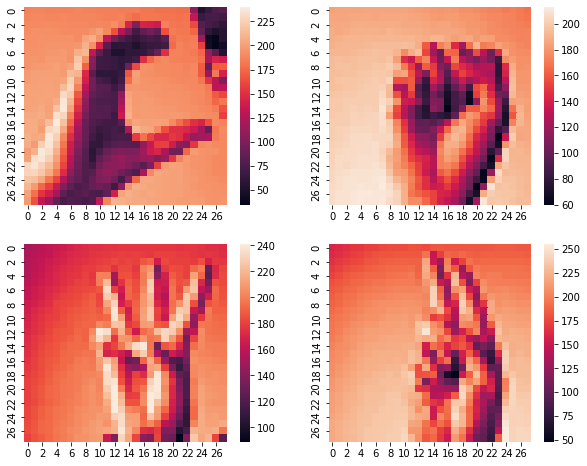

In [ ]:
#show some images in dataset
plt.figure(figsize=(10, 8))

pixels = data[2].reshape(28, 28)
plt.subplot(221)
sns.heatmap(data=pixels)

pixels = data[20002].reshape(28, 28)
plt.subplot(222)
sns.heatmap(data=pixels)

pixels = data[472].reshape(28, 28)
plt.subplot(223)
sns.heatmap(data=pixels)

pixels = data[122].reshape(28, 28)
plt.subplot(224)
sns.heatmap(data=pixels)

In [ ]:
import string

#ID to text labels (encoder)
alph = {0:'a', 1:'b', 2:'c', 3:'d', 4:'e', 5:'f', 6:'g', 7:'h', 8:'i', 9:'j', 10:'k', 11:'l', 12:'m', 13:'n',
        14:'o', 15:'p', 16:'q', 17:'r', 18:'s', 19:'t', 20:'u', 21:'v', 22:'w', 23:'x', 24:'y', 25:'z'}

#reshape function because input data is 1D array
def reshape_to_2d(data, dim):
    reshaped = []
    for i in data:
        reshaped.append(i.reshape(1, dim, dim))

    return np.array(reshaped)

In [ ]:
#reshape input
data = reshape_to_2d(data, 28)

#convert to tensor
x = torch.FloatTensor(data)
y = torch.LongTensor(labels.tolist())

test_labels = torch.LongTensor(labels_test.tolist())

test_data_formated = reshape_to_2d(test_data, 28)
test_data_formated = torch.FloatTensor(test_data_formated)

In [ ]:
#define my CNN
class Network(nn.Module): 
    
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)     #14
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.batchnorm4 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)     #7
        
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3,padding=1) 
        self.batchnorm5 = nn.BatchNorm2d(128)
        self.relu = nn.ReLU()
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3,padding=1) 
        self.batchnorm6 = nn.BatchNorm2d(128)
        self.relu = nn.ReLU()
        # self.pool3 = nn.MaxPool2d(2) 
        # self.dropout1 = nn.Dropout2d()   #3
        
        self.fc3 = nn.Linear(128*7*7, 512) #3x3 is size of image, 30 is 30 features map
        self.fc4 = nn.Linear(512, 26) 
        
        self.softmax = nn.LogSoftmax(dim=1)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.pool1(x)
        
        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.batchnorm4(x)
        x = self.relu(x)
        x = self.pool2(x)
        
        x = self.conv5(x)
        x = self.batchnorm5(x)
        x = self.relu(x)
        x = self.conv6(x)
        x = self.batchnorm6(x)
        x = self.relu(x)
        # x = self.pool3(x)
                
        x = x.view(-1,128*7*7) 
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        
        return self.softmax(x)
    
    #test func
    def test(self, predictions, labels):
        self.eval()
        correct = 0
        for p, l in zip(predictions, labels):
            if p == l:
                correct += 1
        
        acc = correct / len(predictions)
        print("Correct predictions: %5d / %5d (%5f)" % (correct, len(predictions), acc))
        
    #eval function
    def evaluate(self, predictions, labels):
        correct = 0
        for p, l in zip(predictions, labels):
            if p == l:
                correct += 1
        
        acc = correct / len(predictions)
        return(acc)

In [ ]:
#summary network
net = Network()
print(net)

Network(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm5): BatchNorm2d(128, 

In [ ]:
#training parameters
epochs = 50
batch_size = 128
learning_rate = 0.0005

In [ ]:
#Optim and loss func
optimizer = optim.SGD(net.parameters(), learning_rate, momentum=0.7)
loss_func = nn.CrossEntropyLoss()

loss_log = []
acc_log = []

In [ ]:
#Training processing
for e in range(epochs):
    for i in range(0, x.shape[0], batch_size):
        x_mini = x[i:i + batch_size] 
        y_mini = y[i:i + batch_size] 
        
        optimizer.zero_grad()
        net_out = net(Variable(x_mini))
        
        loss = loss_func(net_out, Variable(y_mini))
        loss.backward()
        optimizer.step()
        
        if i % 1000 == 0:
            #pred = net(Variable(test_data_formated))
            loss_log.append(loss.item())
            acc_log.append(net.evaluate(torch.max(net(Variable(test_data_formated[:500])).data, 1)[1], 
                                        test_labels[:500]))
        
    print('Epoch: {} - Loss: {:.6f}'.format(e + 1, loss.item()))

Epoch: 1 - Loss: 2.743257
Epoch: 2 - Loss: 1.896700
Epoch: 3 - Loss: 1.213485
Epoch: 4 - Loss: 0.803927
Epoch: 5 - Loss: 0.556966
Epoch: 6 - Loss: 0.401317
Epoch: 7 - Loss: 0.297525
Epoch: 8 - Loss: 0.226666
Epoch: 9 - Loss: 0.177360
Epoch: 10 - Loss: 0.142302
Epoch: 11 - Loss: 0.116394
Epoch: 12 - Loss: 0.097083
Epoch: 13 - Loss: 0.082273
Epoch: 14 - Loss: 0.070814
Epoch: 15 - Loss: 0.061679
Epoch: 16 - Loss: 0.054305
Epoch: 17 - Loss: 0.048251
Epoch: 18 - Loss: 0.043241
Epoch: 19 - Loss: 0.039022
Epoch: 20 - Loss: 0.035428
Epoch: 21 - Loss: 0.032359
Epoch: 22 - Loss: 0.029733
Epoch: 23 - Loss: 0.027450
Epoch: 24 - Loss: 0.025452
Epoch: 25 - Loss: 0.023687
Epoch: 26 - Loss: 0.022124
Epoch: 27 - Loss: 0.020730
Epoch: 28 - Loss: 0.019477
Epoch: 29 - Loss: 0.018345
Epoch: 30 - Loss: 0.017321
Epoch: 31 - Loss: 0.016392
Epoch: 32 - Loss: 0.015544
Epoch: 33 - Loss: 0.014771
Epoch: 34 - Loss: 0.014059
Epoch: 35 - Loss: 0.013406
Epoch: 36 - Loss: 0.012806
Epoch: 37 - Loss: 0.012254
Epoch: 38 

In [ ]:
#Save model
torch.save(net.state_dict(),'ThanhTam0612.pth')

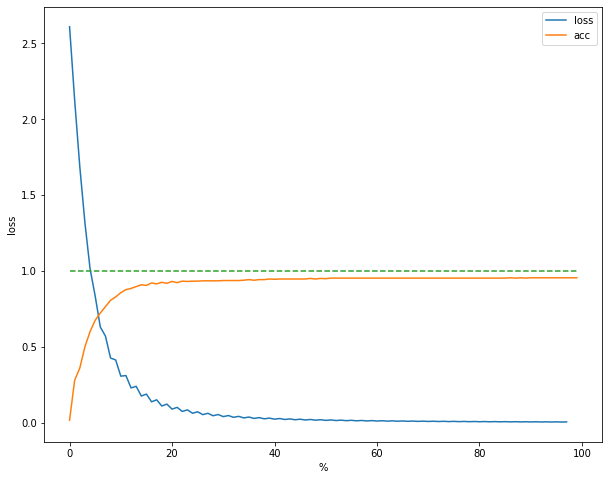

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

#Draw loss chart, training accuracy
plt.figure(figsize=(10,8))
plt.plot(loss_log[2:],label='loss')
plt.plot(acc_log,label='acc')
plt.xlabel('%')
plt.ylabel('loss')
plt.legend()
plt.plot(np.ones(len(acc_log)), linestyle='dashed')

In [ ]:
#Load model
net.load_state_dict(torch.load('ThanhTam0612.pth'))

In [ ]:
#test on test dataset
predictions = net(Variable(test_data_formated))
net.test(torch.max(predictions.data, 1)[1], test_labels)

Correct predictions:  6891 /  7172 (0.960820)


Prediction: v, Probability: 0.98
Actual Label: v
Prediction: w, Probability: 0.99
Actual Label: w
Prediction: m, Probability: 0.76
Actual Label: m
Prediction: t, Probability: 0.85
Actual Label: t


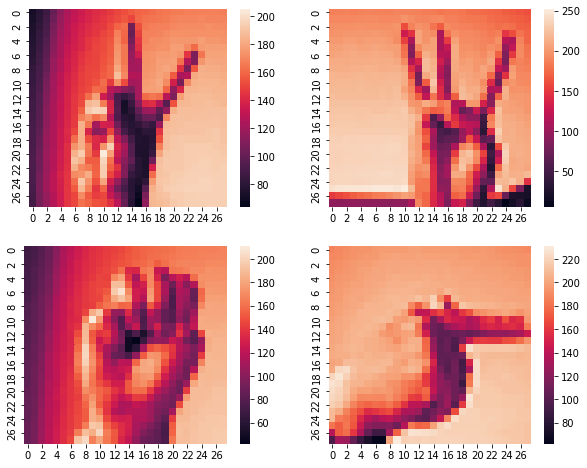

In [ ]:
#cal probality
def cal_prob(pred): 
  m = np.exp(net_out_sample.detach().numpy())
  return str(round(m.max(),2))



plt.figure(figsize=(10, 8))

sample = 5
pixels = test_data[sample].reshape(28, 28)
plt.subplot(221)
plt.imshow(pixels)
sns.heatmap(data=pixels)
lab = labels_test[sample]
test_sample = torch.FloatTensor([test_data[sample].reshape(1, 28, 28).tolist()])
test_var_sample = Variable(test_sample)
net_out_sample = net(test_var_sample)

print("Prediction: {}, Probability: {}".format(alph[torch.max(net_out_sample.data, 1)[1].numpy()[0]], cal_prob(net_out_sample)))
print("Actual Label: {}".format(alph[lab]))

sample = 51
pixels = test_data[sample].reshape(28, 28)
plt.subplot(222)
sns.heatmap(data=pixels)
lab = labels_test[sample]
test_sample = torch.FloatTensor([test_data[sample].reshape(1, 28, 28).tolist()])
test_var_sample = Variable(test_sample)
net_out_sample = net(test_var_sample)

print("Prediction: {}, Probability: {}".format(alph[torch.max(net_out_sample.data, 1)[1].numpy()[0]], cal_prob(net_out_sample)))
print("Actual Label: {}".format(alph[lab]))

sample = 501
pixels = test_data[sample].reshape(28, 28)
plt.subplot(223)
sns.heatmap(data=pixels)
lab = labels_test[sample]
test_sample = torch.FloatTensor([test_data[sample].reshape(1, 28, 28).tolist()])
test_var_sample = Variable(test_sample)
net_out_sample = net(test_var_sample)

print("Prediction: {}, Probability: {}".format(alph[torch.max(net_out_sample.data, 1)[1].numpy()[0]], cal_prob(net_out_sample)))
print("Actual Label: {}".format(alph[lab]))

sample = 5001
pixels = test_data[sample].reshape(28, 28)
plt.subplot(224)
sns.heatmap(data=pixels)
lab = labels_test[sample]
test_sample = torch.FloatTensor([test_data[sample].reshape(1, 28, 28).tolist()])
test_var_sample = Variable(test_sample)
net_out_sample = net(test_var_sample)

print("Prediction: {}, Probability: {}".format(alph[torch.max(net_out_sample.data, 1)[1].numpy()[0]], cal_prob(net_out_sample)))
print("Actual Label: {}".format(alph[lab]))

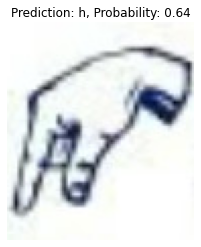

In [ ]:
import cv2


path_link = "/content/drive/MyDrive/Colab Notebooks/0612/Untitled12345678.jpg"

#read image and copy to save original image
img = cv2.imread(path_link)
img2 = img
img2 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img-50, (28,28))
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#put img into model order to predicts
test_data = img
test_sample = torch.FloatTensor([test_data.reshape(1, 28, 28).tolist()])
test_var_sample = Variable(test_sample)
net_out_sample = net(test_var_sample)

#draw plot
preds = "Prediction: {}, Probability: {}".format(alph[torch.max(net_out_sample.data, 1)[1].numpy()[0]], cal_prob(net_out_sample))
plt.title(preds)
plt.axis('off')
plt.imshow(img2)

#save img
#name_save = "output_" + str(path_link)
#plt.savefig(name_save)

plt.show()

In [ ]:
from google.colab.output import eval_js
from IPython.display import display, Javascript, Image

# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
import PIL
import io
from base64 import b64decode, b64encode
import cv2
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 


while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale image for face detection
    gray = img[0:300,0:300]
    gray = cv2.cvtColor(gray, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, (28,28))
    # cv2.imwrite("cap.png", gray)

    test_sample = torch.FloatTensor([gray.reshape(1, 28, 28).tolist()])
    test_var_sample = Variable(test_sample)
    net_out_sample = net(test_var_sample)
    name = alph[torch.max(net_out_sample.data, 1)[1].numpy()[0]]

    m = np.exp(net_out_sample.detach().numpy())
    p = round(m.max(),2)
    name = str(name) + ", " + str(p)
    if(p>0.3):
      cv2.putText(bbox_array, str(name), (65,50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), thickness=2)

    bbox_array = cv2.rectangle(bbox_array,(0,0),(300,300),(255,0,0),2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>